In [1]:
import os
os.chdir("/staging/leuven/stg_00002/lcb/sdewin/PhD/python_modules/scenicplus_development_tutorial")

In [3]:
!scenicplus


   ____   ____ _____ _   _ ___ ____      
  / ___| / ___| ____| \ | |_ _/ ___| _ 
  \___ \| |   |  _| |  \| || | |   _|.|_
   ___) | |___| |___| |\  || | |__|_..._|
  |____/ \____|_____|_| \_|___\____||_| 


scenicplus verions: 1.0a1
usage: scenicplus [-h] {init_snakemake,prepare_data,grn_inference} ...

Single-Cell Enhancer-driven gene regulatory Network Inference and Clustering

positional arguments:
  {init_snakemake,prepare_data,grn_inference}

options:
  -h, --help            show this help message and exit


## Data preparation

In [11]:
data_dir = "data"
os.makedirs(data_dir, exist_ok = True)

### Prepare candidate enhancer regions

### Save binarized region topics as bed file

In [13]:
os.makedirs(os.path.join(data_dir, "region_sets"), exist_ok = True)

In [5]:
import pickle
cistopic_obj = pickle.load(
    open(
        "/staging/leuven/stg_00002/lcb/cbravo/Multiomics_pipeline/analysis/10x_multiome_brain/output/atac/tutorial/10x_multiome_brain_cisTopicObject_noDBL.pkl",
        "rb"
    )
)

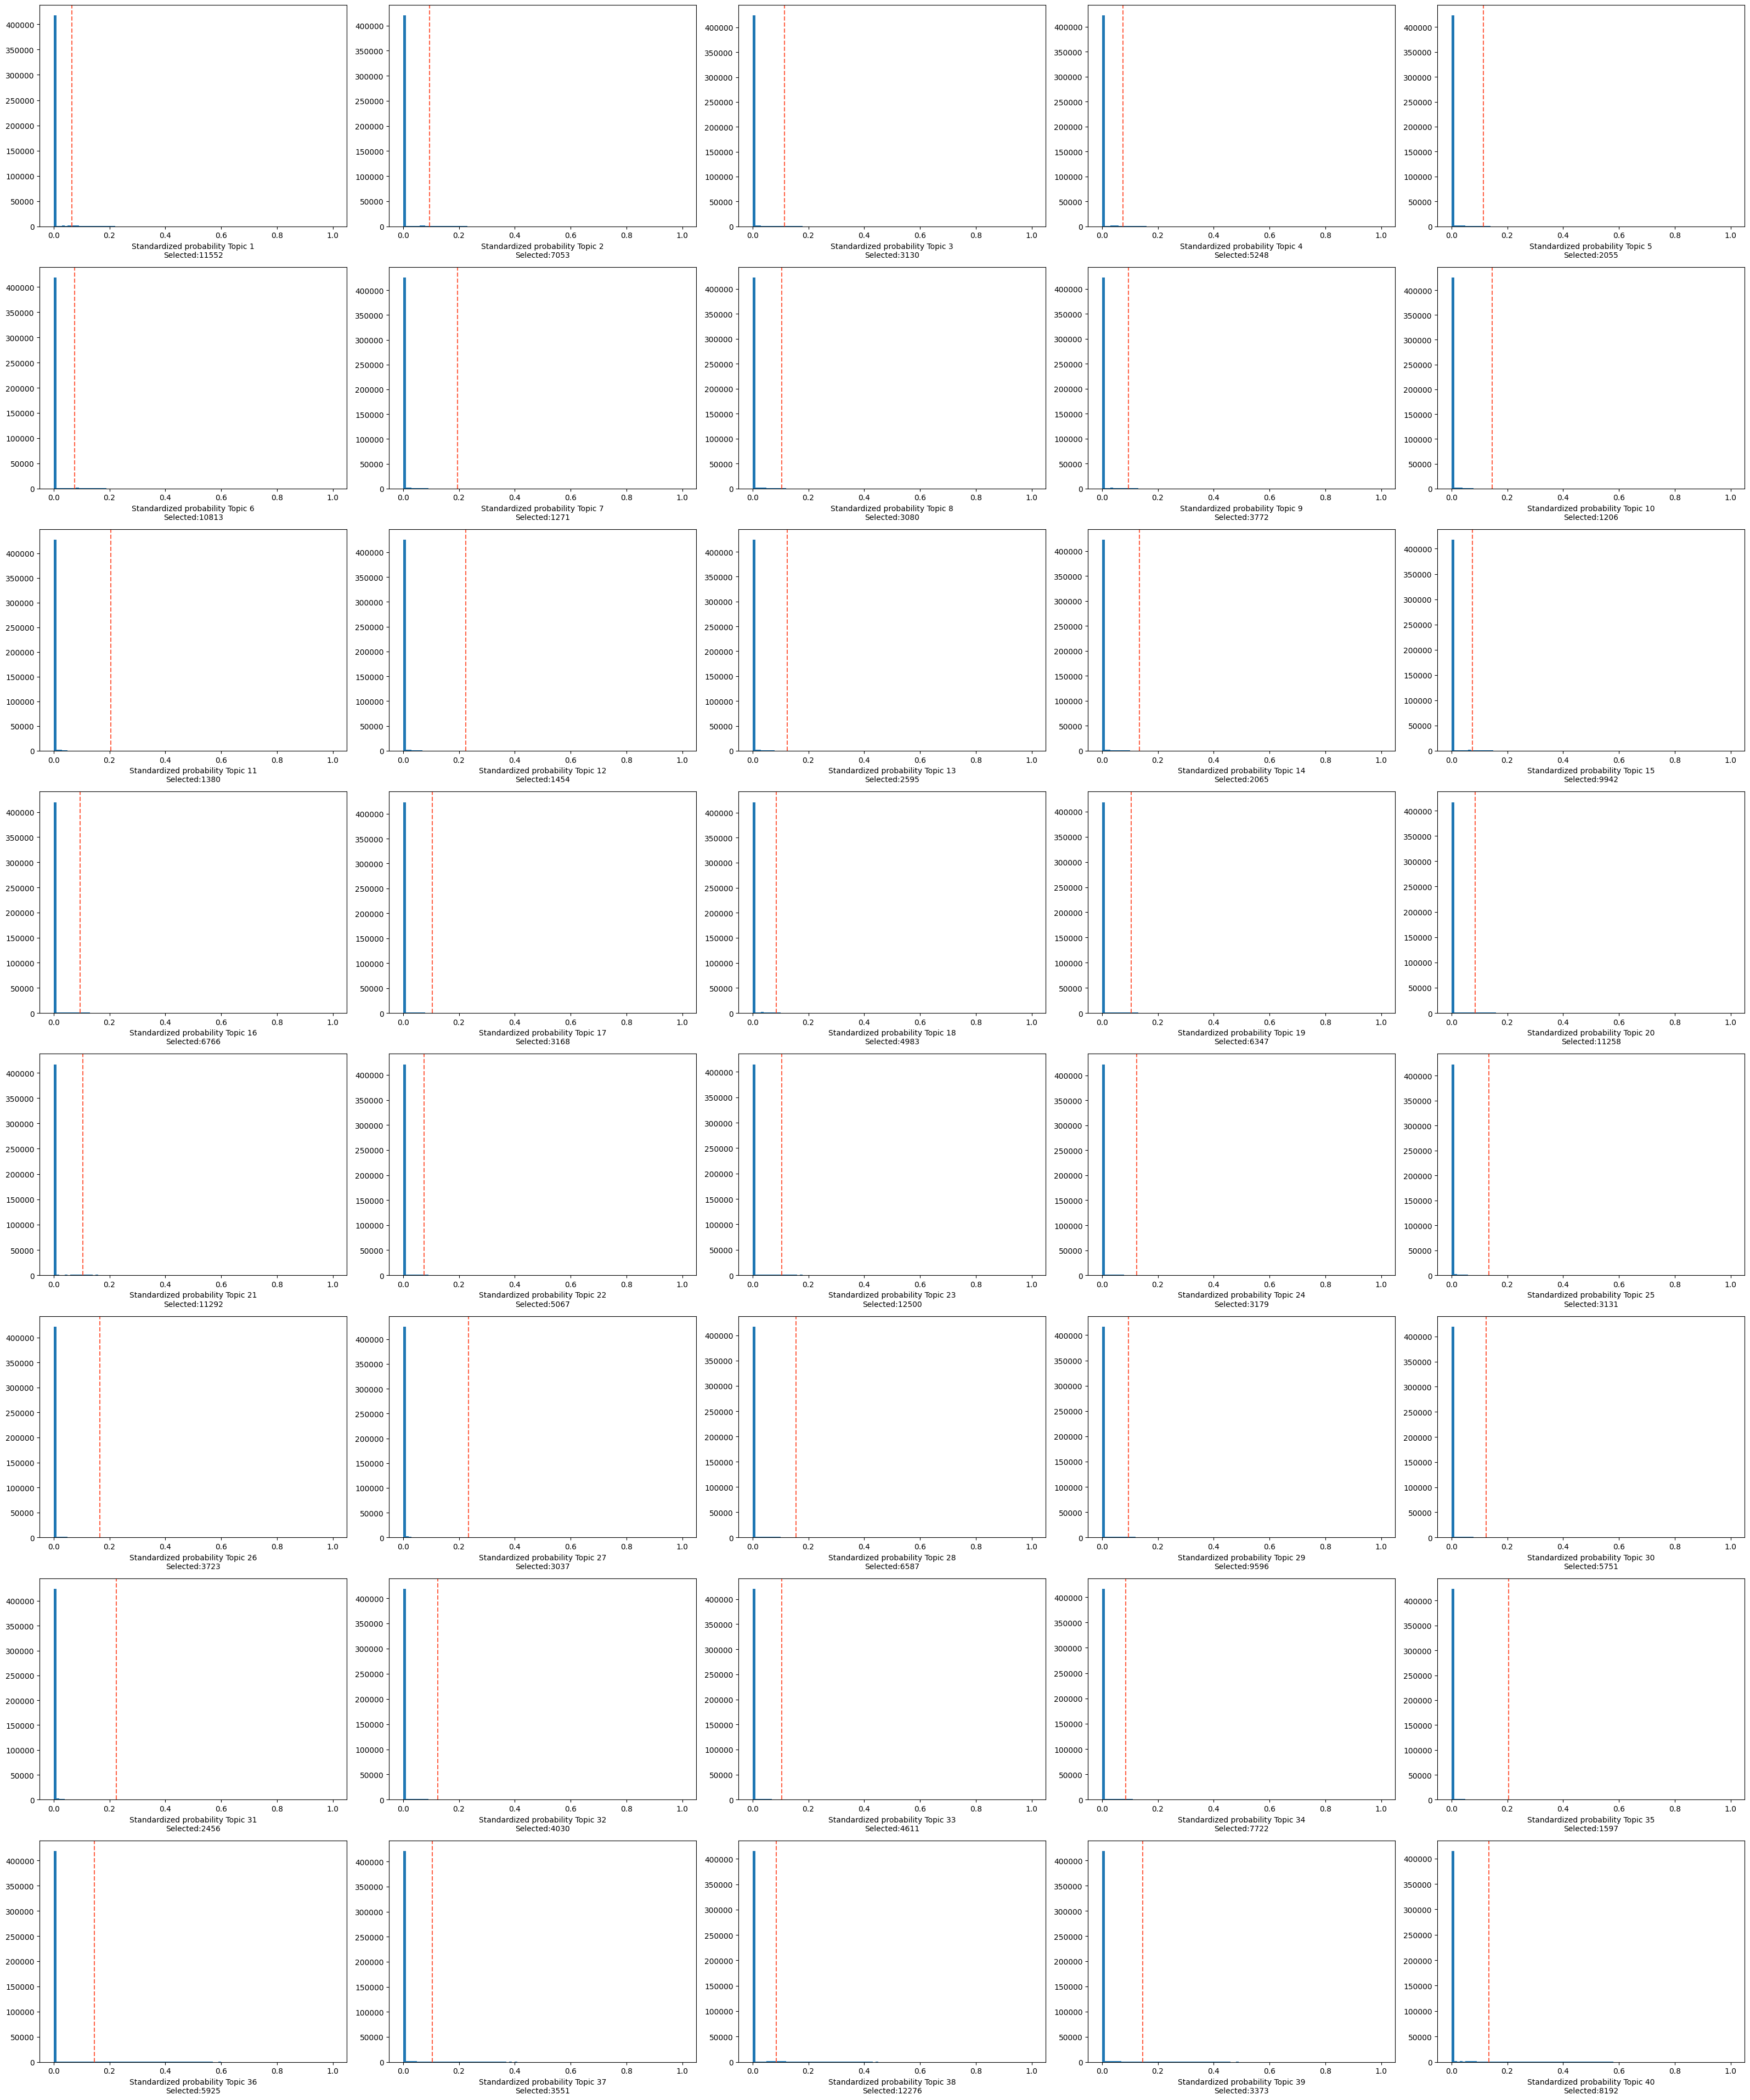

In [9]:
from pycisTopic.topic_binarization import binarize_topics
region_bin_topics_otsu = binarize_topics(
    cistopic_obj,
    method='otsu',
    num_columns=5,
    plot=True)

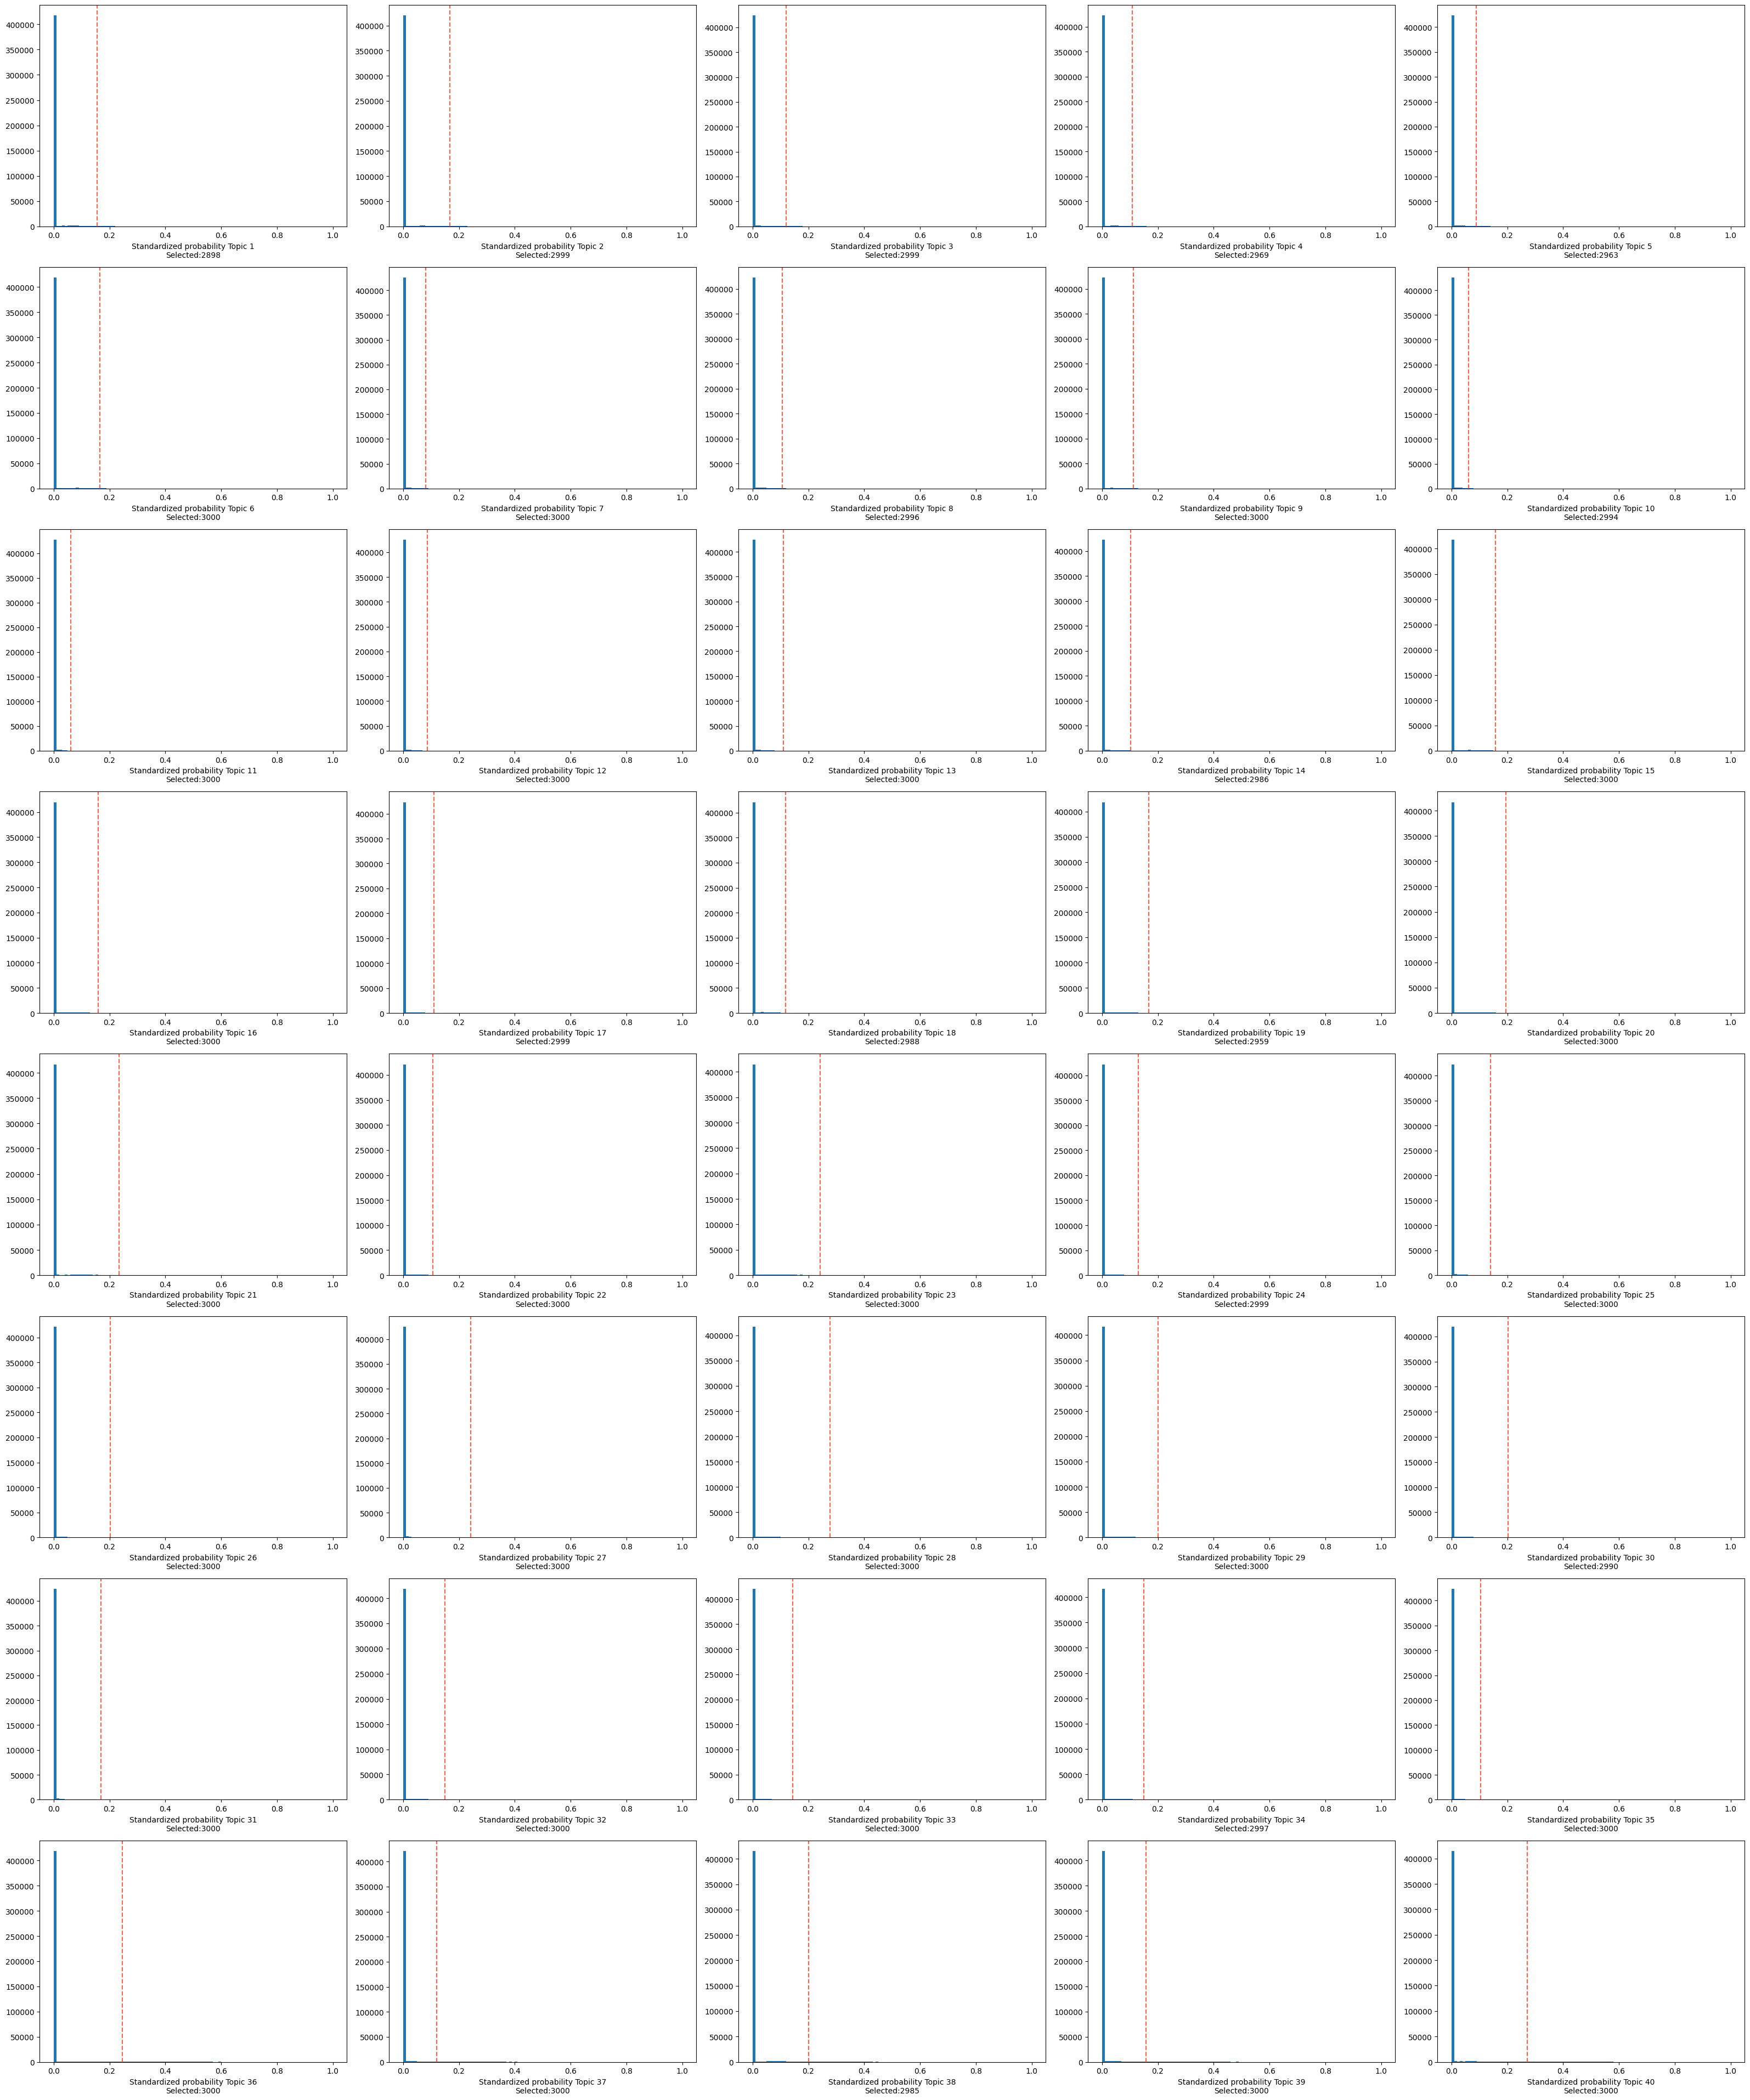

In [10]:
region_bin_topics_top3k = binarize_topics(
    cistopic_obj,
    method='ntop',
    ntop = 3_000,
    num_columns=5,
    plot=True)

In [20]:
from scenicplus.utils import region_names_to_coordinates

In [38]:
os.makedirs(os.path.join(data_dir, "region_sets", "topics_otsu"), exist_ok = True)
for topic in region_bin_topics_otsu:
    region_names_to_coordinates(
        region_bin_topics_otsu[topic].index
    ).sort_values(
        ["Chromosome", "Start", "End"]
    ).to_csv(
        os.path.join(data_dir, "region_sets", "topics_otsu", f"{topic}.bed"),
        sep = "\t", header = False, index = False
    )

In [39]:
os.makedirs(os.path.join(data_dir, "region_sets", "topics_top_3k"), exist_ok = True)
for topic in region_bin_topics_top3k:
    region_names_to_coordinates(
        region_bin_topics_top3k[topic].index
    ).sort_values(
        ["Chromosome", "Start", "End"]
    ).to_csv(
        os.path.join(data_dir, "region_sets", "topics_top_3k", f"{topic}.bed"),
        sep = "\t", header = False, index = False
    )

### Save Differentially Accessibile Regions (DARs) as bed file

In [33]:
from pycisTopic.diff_features import (
    impute_accessibility,
    normalize_scores,
    find_highly_variable_features,
    find_diff_features
)
import numpy as np

In [25]:
imputed_acc_obj = impute_accessibility(
    cistopic_obj,
    selected_cells=None,
    selected_regions=None,
    scale_factor=10**6
)

2024-03-06 13:23:27,530 cisTopic     INFO     Imputing region accessibility
2024-03-06 13:23:27,531 cisTopic     INFO     Impute region accessibility for regions 0-20000
2024-03-06 13:23:27,914 cisTopic     INFO     Impute region accessibility for regions 20000-40000
2024-03-06 13:23:28,219 cisTopic     INFO     Impute region accessibility for regions 40000-60000
2024-03-06 13:23:28,519 cisTopic     INFO     Impute region accessibility for regions 60000-80000
2024-03-06 13:23:28,825 cisTopic     INFO     Impute region accessibility for regions 80000-100000
2024-03-06 13:23:29,129 cisTopic     INFO     Impute region accessibility for regions 100000-120000
2024-03-06 13:23:29,431 cisTopic     INFO     Impute region accessibility for regions 120000-140000
2024-03-06 13:23:29,732 cisTopic     INFO     Impute region accessibility for regions 140000-160000
2024-03-06 13:23:30,034 cisTopic     INFO     Impute region accessibility for regions 160000-180000
2024-03-06 13:23:30,338 cisTopic     

In [26]:
normalized_imputed_acc_obj = normalize_scores(imputed_acc_obj, scale_factor=10**4)

2024-03-06 13:23:44,794 cisTopic     INFO     Normalizing imputed data
2024-03-06 13:23:50,271 cisTopic     INFO     Done!


2024-03-06 13:24:29,221 cisTopic     INFO     Calculating mean
2024-03-06 13:24:30,445 cisTopic     INFO     Calculating variance


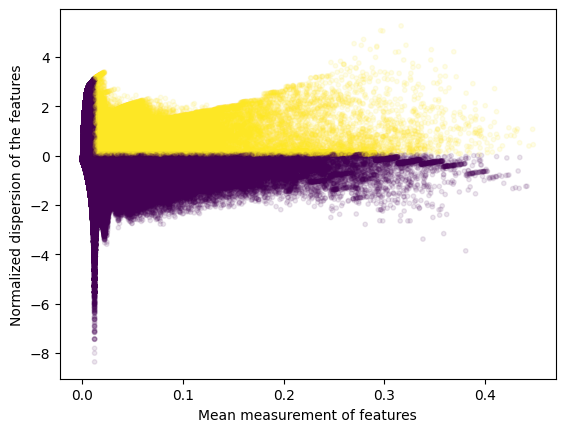

2024-03-06 13:24:46,795 cisTopic     INFO     Done!


In [31]:
variable_regions = find_highly_variable_features(
    normalized_imputed_acc_obj,
    min_disp = 0.05,
    min_mean = 0.0125,
    max_mean = 3,
    max_disp = np.inf,
    n_bins=20,
    n_top_features=None,
    plot=True
)

In [34]:
markers_dict= find_diff_features(
    cistopic_obj,
    imputed_acc_obj,
    variable='Seurat_cell_type',
    var_features=variable_regions,
    contrasts=None,
    adjpval_thr=0.05,
    log2fc_thr=np.log2(1.5),
    n_cpu=20,
    _temp_dir="/scratch/leuven/330/vsc33053/ray_spill/",
    split_pattern = '-'
)

2024-03-06 13:25:55,898	INFO worker.py:1715 -- Started a local Ray instance. View the dashboard at http://127.0.0.1:8265 


2024-03-06 13:25:56,974 cisTopic     INFO     Subsetting data for AST (30 of 2292)
2024-03-06 13:25:59,254 cisTopic     INFO     Computing p-value for AST
2024-03-06 13:26:03,641 cisTopic     INFO     Computing log2FC for AST
2024-03-06 13:26:04,853 cisTopic     INFO     AST done!
2024-03-06 13:26:04,854 cisTopic     INFO     Subsetting data for BG (276 of 2292)
2024-03-06 13:26:04,945 cisTopic     INFO     Computing p-value for BG
2024-03-06 13:26:07,814 cisTopic     INFO     Computing log2FC for BG
2024-03-06 13:26:07,853 cisTopic     INFO     BG done!
2024-03-06 13:26:07,857 cisTopic     INFO     Subsetting data for COP (58 of 2292)
2024-03-06 13:26:07,890 cisTopic     INFO     Computing p-value for COP
2024-03-06 13:26:10,799 cisTopic     INFO     Computing log2FC for COP
2024-03-06 13:26:10,838 cisTopic     INFO     COP done!
2024-03-06 13:26:10,841 cisTopic     INFO     Subsetting data for ENDO (14 of 2292)
2024-03-06 13:26:10,872 cisTopic     INFO     Computing p-value for ENDO


In [40]:
os.makedirs(os.path.join(data_dir, "region_sets", "DARs_cell_type"), exist_ok = True)
for cell_type in markers_dict:
    region_names_to_coordinates(
        markers_dict[cell_type].index
    ).sort_values(
        ["Chromosome", "Start", "End"]
    ).to_csv(
        os.path.join(data_dir, "region_sets", "DARs_cell_type", f"{cell_type}.bed"),
        sep = "\t", header = False, index = False
    )

### scRNA-seq preparation

scRNA-seq side of the experiment can be processed according to the regular [Scanpy](https://scanpy-tutorials.readthedocs.io/en/latest/pbmc3k.html) tutorial. Just make sure to store the raw gene expresison matrix in `adata.raw`.

**Call the following piece of code:**

```python

adata.raw = adata

```

**_BEFORE_** normalizing the data

```python

sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)

```

In [41]:
ls data

10x_multiome_brain_cisTopicObject_noDBL.pkl@  adata.h5ad@  region_sets/


## Initialize Snakemake

In [45]:
!mkdir -p scplus_pipeline
!scenicplus init_snakemake --out_dir scplus_pipeline

2024-03-06 14:28:10,766 SCENIC+      INFO     Creating snakemake folder in: scplus_pipeline


In [51]:
!tree scplus_pipeline/

scplus_pipeline/
└── Snakemake
    ├── config
    │   └── config.yaml
    └── workflow
        └── Snakefile

3 directories, 2 files


In [2]:
!mkdir -p outs
!mkdir -p tmp

Modify the `config.yaml` file.

In [121]:
!bat scplus_pipeline/Snakemake/config/config.yaml

───────┬────────────────────────────────────────────────────────────────────────
       │ File: scplus_pipeline/Snakemake/config/config.yaml
───────┼────────────────────────────────────────────────────────────────────────
   1   │ input_data:
   2   │   cisTopic_obj_fname: "/staging/leuven/stg_00002/lcb/sdewin/PhD/python_
       │ modules/scenicplus_development_tutorial/data/10x_multiome_brain_cisTopi
       │ cObject_noDBL.pkl"
   3   │   GEX_anndata_fname: "/staging/leuven/stg_00002/lcb/sdewin/PhD/python_m
       │ odules/scenicplus_development_tutorial/data/adata.h5ad"
   4   │   region_set_folder: "/staging/leuven/stg_00002/lcb/sdewin/PhD/python_m
       │ odules/scenicplus_development_tutorial/data/region_sets"
   5   │   ctx_db_fname: "/staging/leuven/stg_00002/lcb/sdewin/PhD/python_module
       │ s/scenicplus_development_tutorial/ctx_db/10x_brain_1kb_bg_with_mask.reg
       │ ions_vs_motifs.rankings.feather"
   6   │   dem_db_fname: "/staging/leuven/stg_00002/lcb/sdewin/PhD/pyt

## Run pipeline

In [7]:
cd scplus_pipeline/Snakemake/

In [8]:
ls

config	workflow


In [14]:
source /staging/leuven/stg_00002/mambaforge/vsc33053/etc/profile.d/conda.sh
conda activate scenicplus_development_tutorial
snakemake --cores 20

Assuming unrestricted shared filesystem usage for local execution.
Building DAG of jobs...
Using shell: /usr/bin/bash
Provided cores: 20
Rules claiming more threads will be scaled down.
Job stats:
job                            count
---------------------------  -------
AUCell_direct                      1
AUCell_extended                    1
all                                1
download_genome_annotations        1
eGRN_direct                        1
eGRN_extended                      1
get_search_space                   1
motif_enrichment_cistarget         1
motif_enrichment_dem               1
prepare_menr                       1
region_to_gene                     1
scplus_mudata                      1
tf_to_gene                         1
total                             13

Select jobs to execute...
Execute 1 jobs...

[Mon Mar 11 15:16:45 2024]
localrule motif_enrichment_cistarget:
    input: /staging/leuven/stg_00002/lcb/sdewin/PhD/python_modules/scenicplus_development_tutorial/d

In [ ]:
cd ../..

In [21]:
tree outs

outs
├── ACC_GEX.h5mu
├── AUCell_direct.h5mu
├── AUCell_extended.h5mu
├── chromsizes.tsv
├── cistromes_direct.h5ad
├── cistromes_extended.h5ad
├── ctx_results.hdf5
├── ctx_results.html
├── dem_results.hdf5
├── dem_results.html
├── eRegulon_direct.tsv
├── eRegulons_extended.tsv
├── genome_annotation.tsv
├── region_to_gene_adj.tsv
├── scplusmdata.h5mu
├── search_space.tsv
├── tf_names.txt
└── tf_to_gene_adj.tsv

0 directories, 18 files


## Main outputs

In [2]:
import os
os.chdir("/staging/leuven/stg_00002/lcb/sdewin/PhD/python_modules/scenicplus_development_tutorial")

In [3]:
import mudata
scplus_mdata = mudata.read("outs/scplusmdata.h5mu")

/lustre1/project/stg_00002/mambaforge/vsc33053/envs/scenicplus_development_tutorial/lib/python3.11/site-packages/anndata/_core/anndata.py:522: FutureWarning: The dtype argument is deprecated and will be removed in late 2024.
  warnings.warn(
/lustre1/project/stg_00002/mambaforge/vsc33053/envs/scenicplus_development_tutorial/lib/python3.11/site-packages/anndata/_core/anndata.py:522: FutureWarning: The dtype argument is deprecated and will be removed in late 2024.
  warnings.warn(
/lustre1/project/stg_00002/mambaforge/vsc33053/envs/scenicplus_development_tutorial/lib/python3.11/site-packages/anndata/_core/anndata.py:522: FutureWarning: The dtype argument is deprecated and will be removed in late 2024.
  warnings.warn(
/lustre1/project/stg_00002/mambaforge/vsc33053/envs/scenicplus_development_tutorial/lib/python3.11/site-packages/anndata/_core/anndata.py:522: FutureWarning: The dtype argument is deprecated and will be removed in late 2024.
  warnings.warn(
/lustre1/project/stg_00002/mamba

In [103]:
scplus_mdata.uns["direct_e_regulon_metadata"]

,Region,Gene,importance_R2G,rho_R2G,importance_x_rho,importance_x_abs_rho,TF,is_extended,eRegulon_name,Gene_signature_name,Region_signature_name,importance_TF2G,regulation,rho_TF2G,triplet_rank
0,chr14:59428174-59428674,JKAMP,0.016130,0.116968,0.001887,0.001887,BACH2,False,BACH2_direct_+/+,BACH2_direct_+/+_(35g),BACH2_direct_+/+_(40r),0.546841,1,0.066388,5434
1,chr1:43270347-43270847,SZT2,0.006310,0.056373,0.000356,0.000356,BACH2,False,BACH2_direct_+/+,BACH2_direct_+/+_(35g),BACH2_direct_+/+_(40r),0.832071,1,0.052217,4867
2,chr8:23296935-23297435,LOXL2,0.006015,0.055566,0.000334,0.000334,BACH2,False,BACH2_direct_+/+,BACH2_direct_+/+_(35g),BACH2_direct_+/+_(40r),0.844670,1,0.084264,4551
3,chr19:51719716-51720216,ZNF577,0.005975,0.077850,0.000465,0.000465,BACH2,False,BACH2_direct_+/+,BACH2_direct_+/+_(35g),BACH2_direct_+/+_(40r),0.749163,1,0.075323,4838
4,chr20:56362179-56362679,CSTF1,0.014279,0.099998,0.001428,0.001428,BACH2,False,BACH2_direct_+/+,BACH2_direct_+/+_(35g),BACH2_direct_+/+_(40r),0.702624,1,0.067334,5357
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5513,chr6:113995550-113996050,MARCKS,0.048588,-0.276675,-0.013443,0.013443,TCF12,False,TCF12_direct_-/-,TCF12_direct_-/-_(182g),TCF12_direct_-/-_(226r),0.863264,-1,-0.188652,887
5514,chr2:36563159-36563659,CRIM1,0.004615,-0.298982,-0.001380,0.001380,TCF12,False,TCF12_direct_-/-,TCF12_direct_-/-_(182g),TCF12_direct_-/-_(226r),0.837548,-1,-0.240329,5034
5515,chr20:61619693-61620193,CDH4,0.001850,-0.427943,-0.000792,0.000792,TCF12,False,TCF12_direct_-/-,TCF12_direct_-/-_(182g),TCF12_direct_-/-_(226r),1.136335,-1,-0.347234,5060
5516,chr1:177309648-177310148,ASTN1,0.001829,-0.525440,-0.000961,0.000961,TCF12,False,TCF12_direct_-/-,TCF12_direct_-/-_(182g),TCF12_direct_-/-_(226r),3.100724,-1,-0.466647,4521


In [104]:
scplus_mdata.uns["extended_e_regulon_metadata"]

,Region,Gene,importance_R2G,rho_R2G,importance_x_rho,importance_x_abs_rho,TF,is_extended,eRegulon_name,Gene_signature_name,Region_signature_name,importance_TF2G,regulation,rho_TF2G,triplet_rank
0,chr18:70284853-70285353,RTTN,0.035462,0.186654,0.006619,0.006619,IRF8,True,IRF8_extended_+/+,IRF8_extended_+/+_(174g),IRF8_extended_+/+_(235r),0.708803,1,0.219636,3779
1,chr15:22950997-22951497,CYFIP1,0.091225,0.362758,0.033093,0.033093,IRF8,True,IRF8_extended_+/+,IRF8_extended_+/+_(174g),IRF8_extended_+/+_(235r),1.280659,1,0.383998,1291
2,chr1:230211451-230211951,GALNT2,0.039057,0.315432,0.012320,0.012320,IRF8,True,IRF8_extended_+/+,IRF8_extended_+/+_(174g),IRF8_extended_+/+_(235r),1.133609,1,0.200422,2276
3,chr15:50112868-50113368,ATP8B4,0.121814,0.541583,0.065972,0.065972,IRF8,True,IRF8_extended_+/+,IRF8_extended_+/+_(174g),IRF8_extended_+/+_(235r),1.157948,1,0.504137,461
4,chr12:124685110-124685610,SCARB1,0.010957,0.145628,0.001596,0.001596,IRF8,True,IRF8_extended_+/+,IRF8_extended_+/+_(174g),IRF8_extended_+/+_(235r),0.742702,1,0.123779,3931
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4356,chr1:94925620-94926120,ALG14,0.024008,-0.108749,-0.002611,0.002611,TEAD1,True,TEAD1_extended_-/-,TEAD1_extended_-/-_(39g),TEAD1_extended_-/-_(56r),0.372408,-1,-0.059096,4068
4357,chr8:38996534-38997034,ADAM9,0.013814,-0.088579,-0.001224,0.001224,TEAD1,True,TEAD1_extended_-/-,TEAD1_extended_-/-_(39g),TEAD1_extended_-/-_(56r),0.502636,-1,-0.067677,4057
4358,chr10:70672264-70672764,PALD1,0.004041,-0.216303,-0.000874,0.000874,TEAD1,True,TEAD1_extended_-/-,TEAD1_extended_-/-_(39g),TEAD1_extended_-/-_(56r),0.212671,-1,-0.078972,4320
4359,chr11:2747013-2747513,CDKN1C,0.009237,-0.311851,-0.002880,0.002880,TEAD1,True,TEAD1_extended_-/-,TEAD1_extended_-/-_(39g),TEAD1_extended_-/-_(56r),0.154555,-1,-0.147860,4319


In [5]:
import pandas as pd
eRegulons_direct = pd.read_table("outs/eRegulon_direct.tsv")
eRegulons_direct

,Region,Gene,importance_R2G,rho_R2G,importance_x_rho,importance_x_abs_rho,TF,is_extended,eRegulon_name,Gene_signature_name,Region_signature_name,importance_TF2G,regulation,rho_TF2G,triplet_rank
0,chr14:59428174-59428674,JKAMP,0.016130,0.116968,0.001887,0.001887,BACH2,False,BACH2_direct_+/+,BACH2_direct_+/+_(35g),BACH2_direct_+/+_(40r),0.546841,1,0.066388,5434
1,chr1:43270347-43270847,SZT2,0.006310,0.056373,0.000356,0.000356,BACH2,False,BACH2_direct_+/+,BACH2_direct_+/+_(35g),BACH2_direct_+/+_(40r),0.832071,1,0.052217,4867
2,chr8:23296935-23297435,LOXL2,0.006015,0.055566,0.000334,0.000334,BACH2,False,BACH2_direct_+/+,BACH2_direct_+/+_(35g),BACH2_direct_+/+_(40r),0.844670,1,0.084264,4551
3,chr19:51719716-51720216,ZNF577,0.005975,0.077850,0.000465,0.000465,BACH2,False,BACH2_direct_+/+,BACH2_direct_+/+_(35g),BACH2_direct_+/+_(40r),0.749163,1,0.075323,4838
4,chr20:56362179-56362679,CSTF1,0.014279,0.099998,0.001428,0.001428,BACH2,False,BACH2_direct_+/+,BACH2_direct_+/+_(35g),BACH2_direct_+/+_(40r),0.702624,1,0.067334,5357
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5513,chr6:113995550-113996050,MARCKS,0.048588,-0.276675,-0.013443,0.013443,TCF12,False,TCF12_direct_-/-,TCF12_direct_-/-_(182g),TCF12_direct_-/-_(226r),0.863264,-1,-0.188652,887
5514,chr2:36563159-36563659,CRIM1,0.004615,-0.298982,-0.001380,0.001380,TCF12,False,TCF12_direct_-/-,TCF12_direct_-/-_(182g),TCF12_direct_-/-_(226r),0.837548,-1,-0.240329,5034
5515,chr20:61619693-61620193,CDH4,0.001850,-0.427943,-0.000792,0.000792,TCF12,False,TCF12_direct_-/-,TCF12_direct_-/-_(182g),TCF12_direct_-/-_(226r),1.136335,-1,-0.347234,5060
5516,chr1:177309648-177310148,ASTN1,0.001829,-0.525440,-0.000961,0.000961,TCF12,False,TCF12_direct_-/-,TCF12_direct_-/-_(182g),TCF12_direct_-/-_(226r),3.100724,-1,-0.466647,4521


In [6]:
eRegulons_extended = pd.read_table("outs/eRegulons_extended.tsv")
eRegulons_extended

,Region,Gene,importance_R2G,rho_R2G,importance_x_rho,importance_x_abs_rho,TF,is_extended,eRegulon_name,Gene_signature_name,Region_signature_name,importance_TF2G,regulation,rho_TF2G,triplet_rank
0,chr18:70284853-70285353,RTTN,0.035462,0.186654,0.006619,0.006619,IRF8,True,IRF8_extended_+/+,IRF8_extended_+/+_(174g),IRF8_extended_+/+_(235r),0.708803,1,0.219636,3779
1,chr15:22950997-22951497,CYFIP1,0.091225,0.362758,0.033093,0.033093,IRF8,True,IRF8_extended_+/+,IRF8_extended_+/+_(174g),IRF8_extended_+/+_(235r),1.280659,1,0.383998,1291
2,chr1:230211451-230211951,GALNT2,0.039057,0.315432,0.012320,0.012320,IRF8,True,IRF8_extended_+/+,IRF8_extended_+/+_(174g),IRF8_extended_+/+_(235r),1.133609,1,0.200422,2276
3,chr15:50112868-50113368,ATP8B4,0.121814,0.541583,0.065972,0.065972,IRF8,True,IRF8_extended_+/+,IRF8_extended_+/+_(174g),IRF8_extended_+/+_(235r),1.157948,1,0.504137,461
4,chr12:124685110-124685610,SCARB1,0.010957,0.145628,0.001596,0.001596,IRF8,True,IRF8_extended_+/+,IRF8_extended_+/+_(174g),IRF8_extended_+/+_(235r),0.742702,1,0.123779,3931
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4356,chr1:94925620-94926120,ALG14,0.024008,-0.108749,-0.002611,0.002611,TEAD1,True,TEAD1_extended_-/-,TEAD1_extended_-/-_(39g),TEAD1_extended_-/-_(56r),0.372408,-1,-0.059096,4068
4357,chr8:38996534-38997034,ADAM9,0.013814,-0.088579,-0.001224,0.001224,TEAD1,True,TEAD1_extended_-/-,TEAD1_extended_-/-_(39g),TEAD1_extended_-/-_(56r),0.502636,-1,-0.067677,4057
4358,chr10:70672264-70672764,PALD1,0.004041,-0.216303,-0.000874,0.000874,TEAD1,True,TEAD1_extended_-/-,TEAD1_extended_-/-_(39g),TEAD1_extended_-/-_(56r),0.212671,-1,-0.078972,4320
4359,chr11:2747013-2747513,CDKN1C,0.009237,-0.311851,-0.002880,0.002880,TEAD1,True,TEAD1_extended_-/-,TEAD1_extended_-/-_(39g),TEAD1_extended_-/-_(56r),0.154555,-1,-0.147860,4319


## Downstream analysis

## eRegulon dimensionality reduction

In [28]:
import scanpy as sc 
import anndata
eRegulon_gene_AUC = anndata.concat(
    [scplus_mdata["direct_gene_based_AUC"], scplus_mdata["extended_gene_based_AUC"]],
    axis = 1,
    ob
)

In [39]:
eRegulon_gene_AUC.obs = scplus_mdata.obs.loc[eRegulon_gene_AUC.obs_names]

In [40]:
sc.pp.neighbors(eRegulon_gene_AUC, use_rep = "X")

In [41]:
sc.tl.umap(eRegulon_gene_AUC)

/lustre1/project/stg_00002/mambaforge/vsc33053/envs/scenicplus_development_tutorial/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:378: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


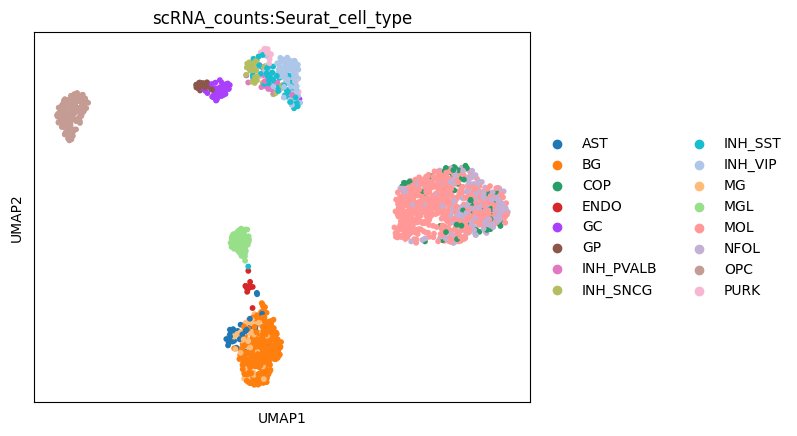

In [43]:
sc.pl.umap(eRegulon_gene_AUC, color = "scRNA_counts:Seurat_cell_type")

## eRegulon specificity score

In [88]:
from scenicplus.RSS import (regulon_specificity_scores, plot_rss)

In [89]:
rss = regulon_specificity_scores(
    scplus_mudata = scplus_mdata,
    variable = "scRNA_counts:Seurat_cell_type",
    modalities = ["direct_gene_based_AUC", "extended_gene_based_AUC"]
)

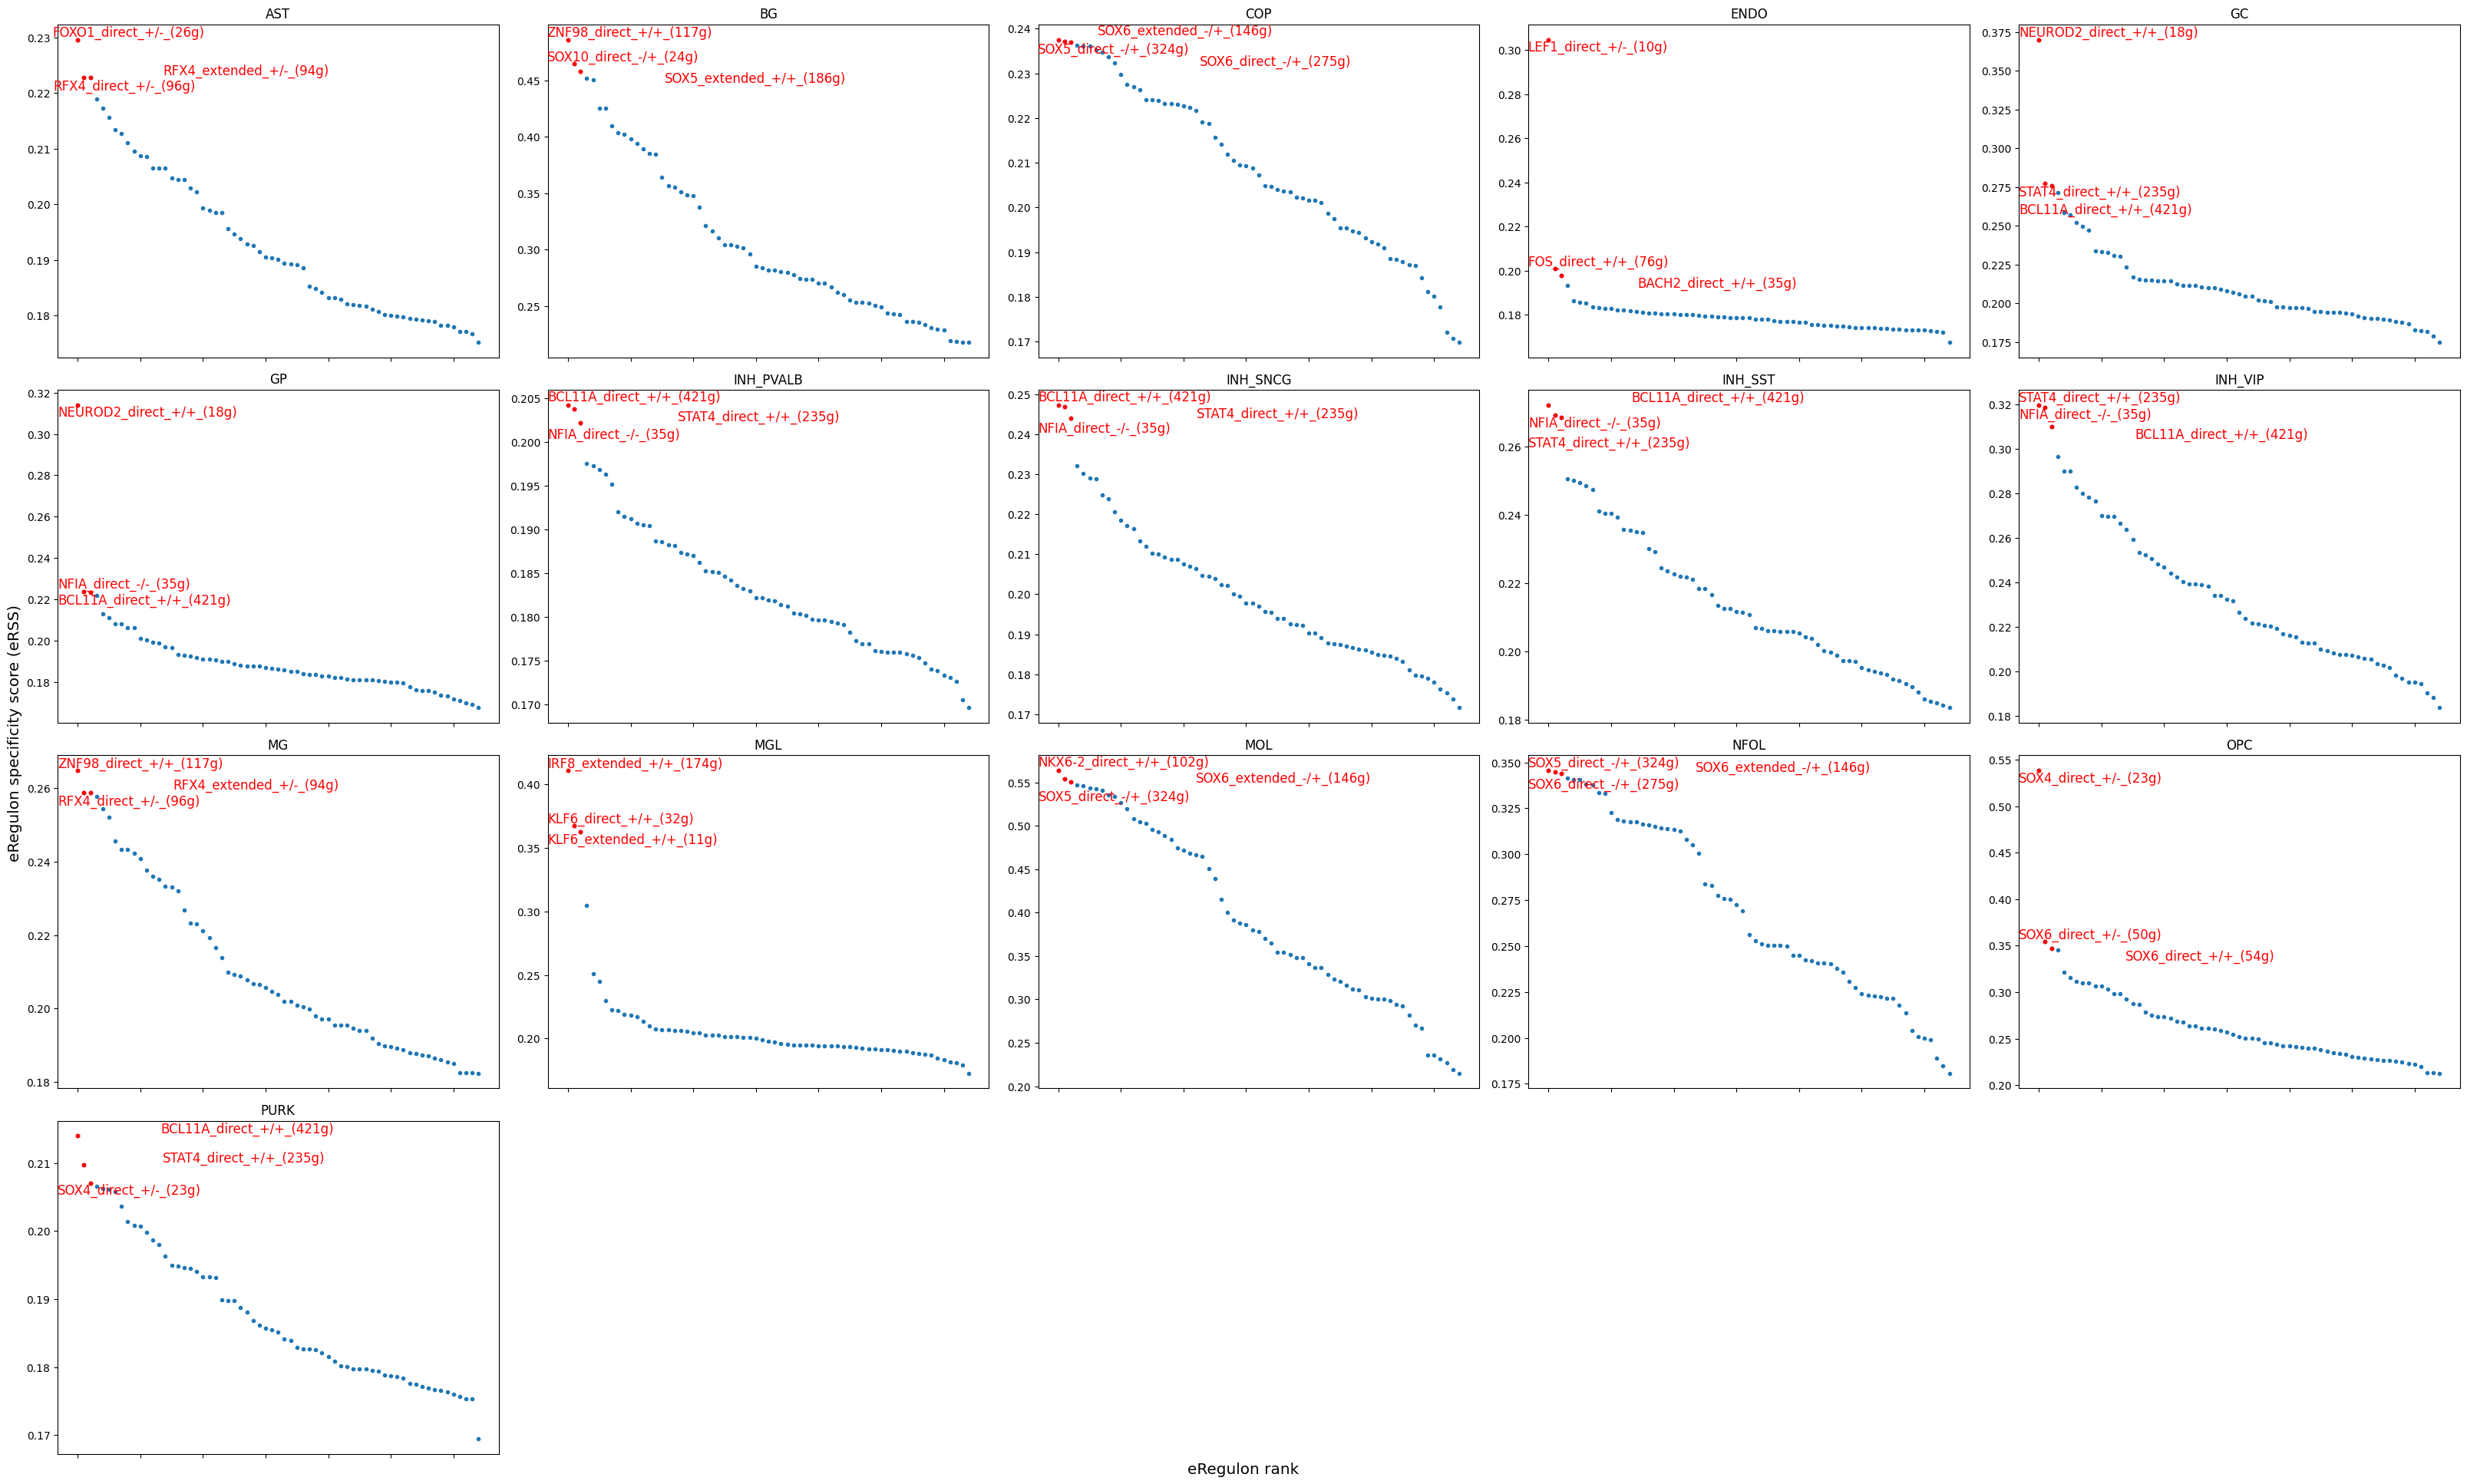

In [90]:
plot_rss(
    data_matrix = rss,
    top_n = 3,
    num_columns = 5
)

## Plot eRegulon enrichment scores

/lustre1/project/stg_00002/mambaforge/vsc33053/envs/scenicplus_development_tutorial/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.print_figure(bytes_io, **kw)


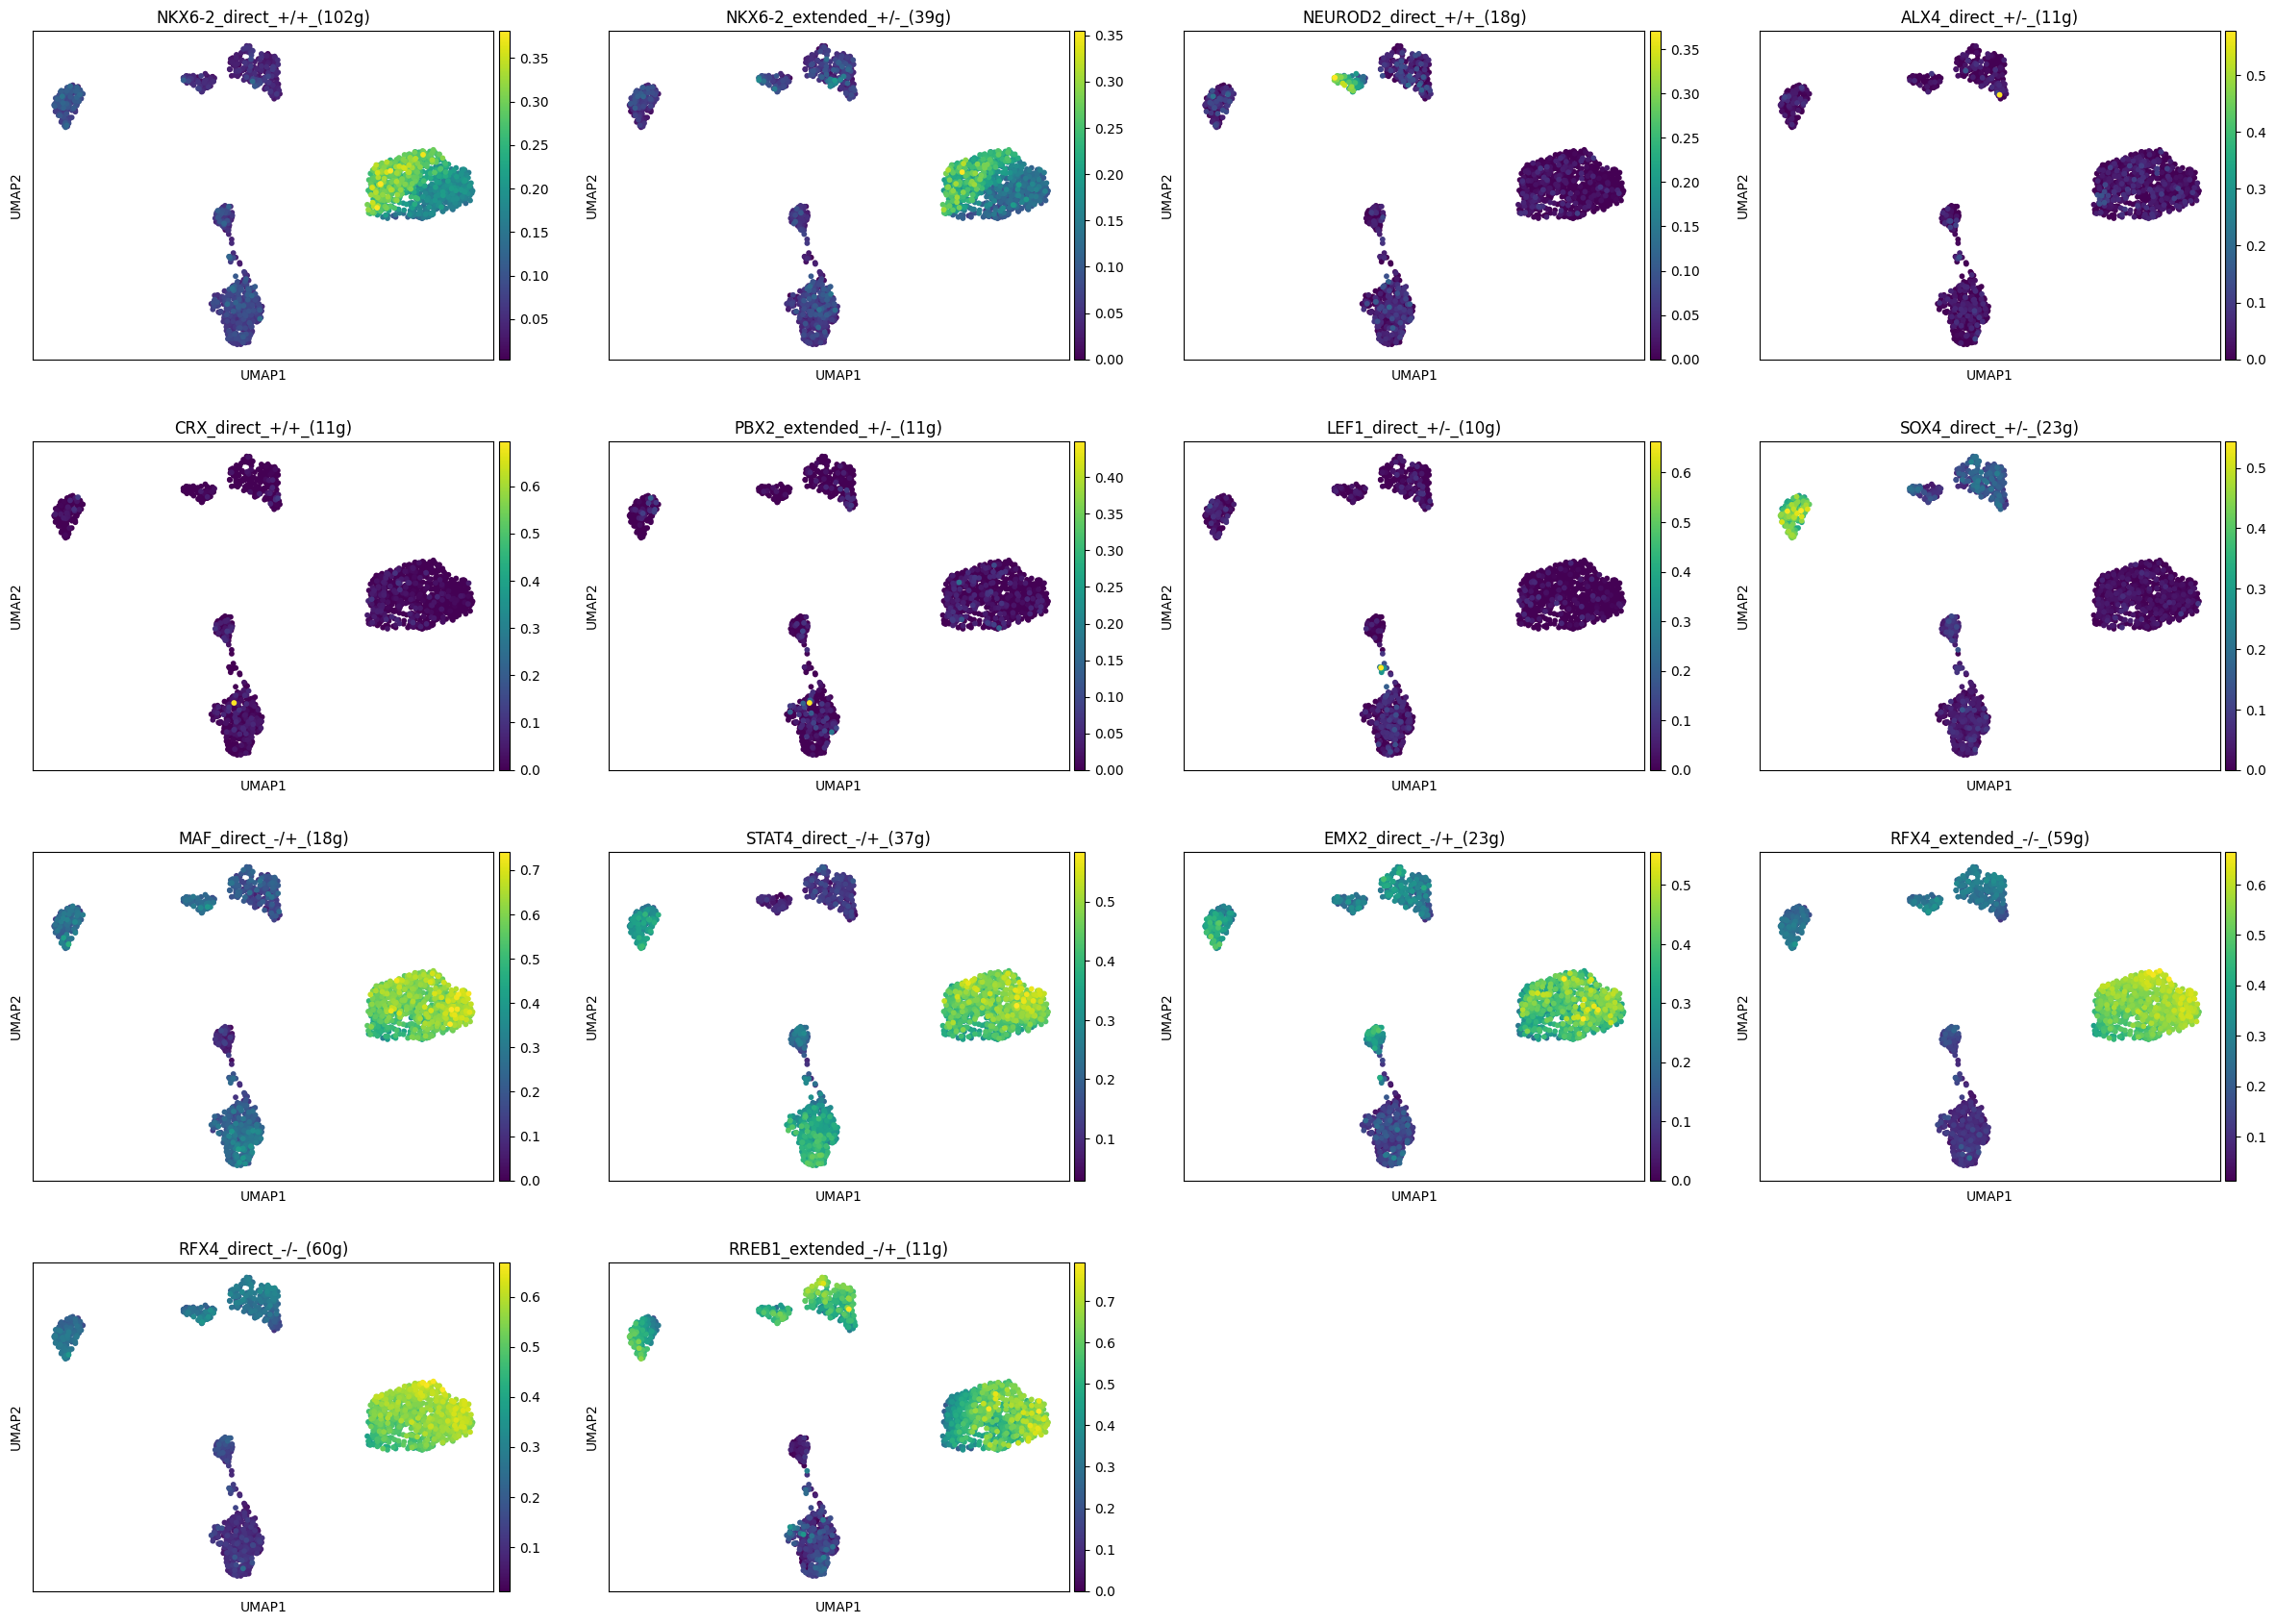

In [96]:
sc.pl.umap(eRegulon_gene_AUC, color = list(set([x for xs in [rss.loc[ct].sort_values()[0:2].index for ct in rss.index] for x in xs ])))

## Heatmap dotplot

In [97]:
from scenicplus.plotting.dotplot import heatmap_dotplot
help(heatmap_dotplot)

Help on function heatmap_dotplot in module scenicplus.plotting.dotplot:

heatmap_dotplot(scplus_mudata: Union[mudata._core.mudata.MuData, scenicplus.scenicplus_mudata.ScenicPlusMuData], size_modality: str, color_modality: str, group_variable: str, eRegulon_metadata_key: str, size_feature_key: str, color_feature_key: str, feature_name_key: str, sort_data_by: str, subset_feature_names: Optional[List[str]] = None, scale_size_matrix: bool = True, scale_color_matrix: bool = True, group_variable_order: Optional[List[str]] = None, save: Optional[str] = None, figsize: Tuple[float, float] = (5, 8), split_repressor_activator: bool = True, orientation: str = 'vertical')



In [105]:
scplus_mdata.uns["direct_e_regulon_metadata"]

,Region,Gene,importance_R2G,rho_R2G,importance_x_rho,importance_x_abs_rho,TF,is_extended,eRegulon_name,Gene_signature_name,Region_signature_name,importance_TF2G,regulation,rho_TF2G,triplet_rank
0,chr14:59428174-59428674,JKAMP,0.016130,0.116968,0.001887,0.001887,BACH2,False,BACH2_direct_+/+,BACH2_direct_+/+_(35g),BACH2_direct_+/+_(40r),0.546841,1,0.066388,5434
1,chr1:43270347-43270847,SZT2,0.006310,0.056373,0.000356,0.000356,BACH2,False,BACH2_direct_+/+,BACH2_direct_+/+_(35g),BACH2_direct_+/+_(40r),0.832071,1,0.052217,4867
2,chr8:23296935-23297435,LOXL2,0.006015,0.055566,0.000334,0.000334,BACH2,False,BACH2_direct_+/+,BACH2_direct_+/+_(35g),BACH2_direct_+/+_(40r),0.844670,1,0.084264,4551
3,chr19:51719716-51720216,ZNF577,0.005975,0.077850,0.000465,0.000465,BACH2,False,BACH2_direct_+/+,BACH2_direct_+/+_(35g),BACH2_direct_+/+_(40r),0.749163,1,0.075323,4838
4,chr20:56362179-56362679,CSTF1,0.014279,0.099998,0.001428,0.001428,BACH2,False,BACH2_direct_+/+,BACH2_direct_+/+_(35g),BACH2_direct_+/+_(40r),0.702624,1,0.067334,5357
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5513,chr6:113995550-113996050,MARCKS,0.048588,-0.276675,-0.013443,0.013443,TCF12,False,TCF12_direct_-/-,TCF12_direct_-/-_(182g),TCF12_direct_-/-_(226r),0.863264,-1,-0.188652,887
5514,chr2:36563159-36563659,CRIM1,0.004615,-0.298982,-0.001380,0.001380,TCF12,False,TCF12_direct_-/-,TCF12_direct_-/-_(182g),TCF12_direct_-/-_(226r),0.837548,-1,-0.240329,5034
5515,chr20:61619693-61620193,CDH4,0.001850,-0.427943,-0.000792,0.000792,TCF12,False,TCF12_direct_-/-,TCF12_direct_-/-_(182g),TCF12_direct_-/-_(226r),1.136335,-1,-0.347234,5060
5516,chr1:177309648-177310148,ASTN1,0.001829,-0.525440,-0.000961,0.000961,TCF12,False,TCF12_direct_-/-,TCF12_direct_-/-_(182g),TCF12_direct_-/-_(226r),3.100724,-1,-0.466647,4521


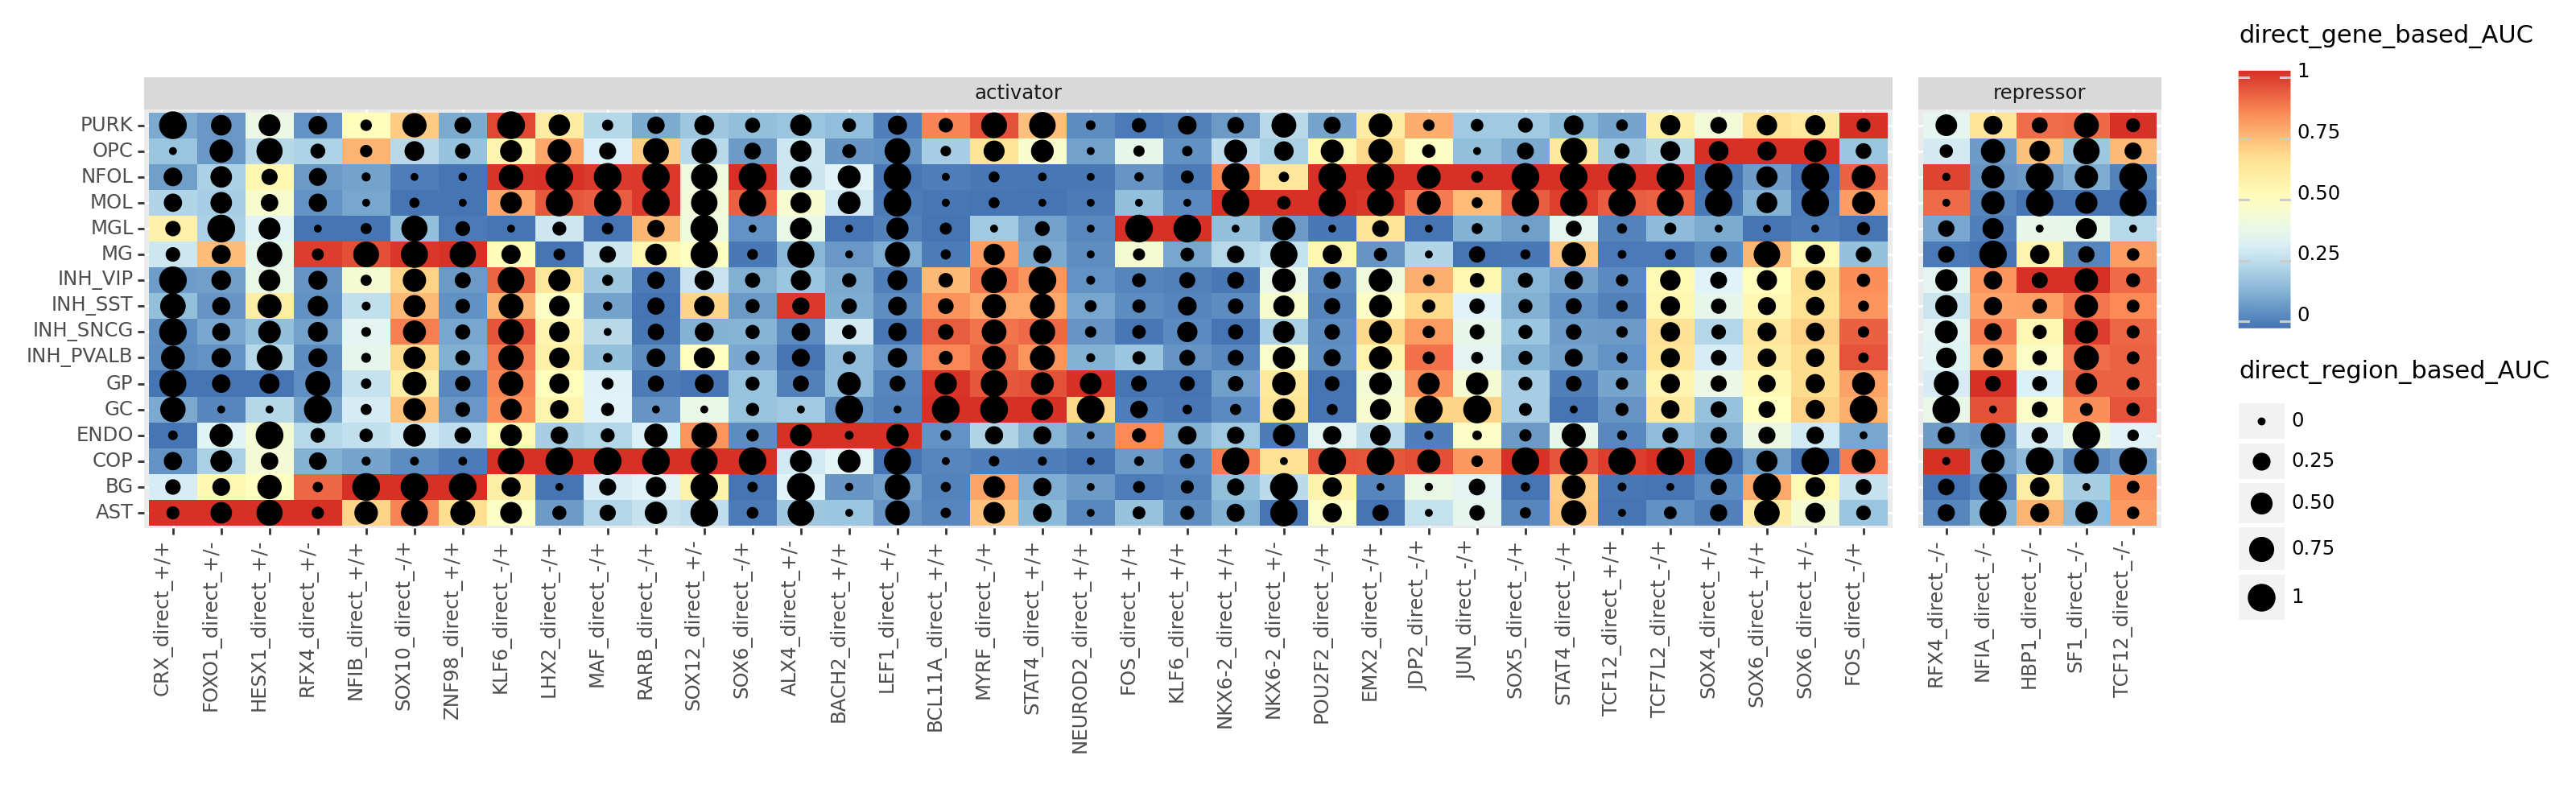

<Figure Size: (1600 x 500)>

In [119]:
heatmap_dotplot(
    scplus_mudata = scplus_mdata,
    color_modality = "direct_gene_based_AUC",
    size_modality = "direct_region_based_AUC",
    group_variable = "scRNA_counts:Seurat_cell_type",
    eRegulon_metadata_key = "direct_e_regulon_metadata",
    color_feature_key = "Gene_signature_name",
    size_feature_key = "Region_signature_name",
    feature_name_key = "eRegulon_name",
    sort_data_by = "direct_gene_based_AUC",
    orientation = "horizontal",
    figsize = (16, 5)
)